In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [30]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
PANGOLIN_PREDICTIONS = "../data/pangolin_predictions"
GENE_NAME_MAPPING = "../data/ref/gene_mappings.tsv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files/dir
PLOTS_DIR = "../results/PCAWG"
os.makedirs(PLOTS_DIR, exist_ok=True)
PLOT_DATA_DIR = "../plot_data/splicing_pangolin"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

CANCER_TYPES = os.listdir(PANGOLIN_PREDICTIONS)
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith("_pred.csv")]
CANCER_TYPES = [cancer_type.replace("_pred.csv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['Myeloid-AML', 'Lung-SCC', 'Prost-AdenoCA', 'Lymph-CLL', 'CNS-Oligo', 'CNS-Medullo', 'Breast-LobularCa', 'Kidney-ChRCC', 'ColoRect-AdenoCA', 'Panc-Endocrine', 'Eso-AdenoCa', 'Skin-Melanoma', 'Bone-Leiomyo', 'Biliary-AdenoCA', 'Uterus-AdenoCA', 'Head-SCC', 'Bone-Osteosarc', 'Liver-HCC', 'Lymph-BNHL', 'Panc-AdenoCA', 'Thy-AdenoCA', 'Kidney-RCC', 'Cervix-SCC', 'Breast-AdenoCa', 'CNS-PiloAstro', 'Lung-AdenoCA', 'Stomach-AdenoCA', 'CNS-GBM', 'Myeloid-MPN', 'Ovary-AdenoCA', 'Bladder-TCC']


In [31]:
gene_names = pd.read_csv(GENE_NAME_MAPPING, sep="\t")
# dictionary to map ensemble gene id to gene name
gene_dict = dict(zip(gene_names["ensembl_gene_id"], gene_names["hgnc_symbol"]))
print(len(gene_dict))

70611


In [32]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [33]:
# get pangolin prediction
pangolin_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	pangolin_df_cancer = pd.read_csv(f"{PANGOLIN_PREDICTIONS}/{cancer_type}_pred.csv", sep="\t")
	pangolin_df_cancer.columns = ["data"]
	pangolin_df_cancer["mutation_loc"] = pangolin_df_cancer["data"].apply(lambda x: ':'.join(x.split(",")[:4]))
	pangolin_df_cancer["scores"] = pangolin_df_cancer["data"].apply(lambda x: x.split(",")[4:])
	pangolin_df_cancer = pangolin_df_cancer.drop(columns=["data"])
	pangolin_df_cancer["cancer_type"] = cancer_type
	pangolin_df = pd.concat([pangolin_df, pangolin_df_cancer], axis=0)
print(pangolin_df.shape)

# separate rows for scores for multiple genes
pangolin_df = pangolin_df.explode("scores")
print(pangolin_df.shape)

# drop rows with no scores
pangolin_df = pangolin_df[pangolin_df["scores"] != ""]
print(pangolin_df.shape)

# display warnings if any, clean up the data
pangolin_df["warning"] = pangolin_df["scores"].apply(lambda x: x.split("|Warnings:")[1] if "|Warnings:" in x else "")
pangolin_df["scores"] = pangolin_df["scores"].apply(lambda x: x.split("|Warnings:")[0])
warnings = pangolin_df[pangolin_df["warning"] != ""]["warning"].tolist()
if warnings:
	print(f"Warnings: {warnings}")
pangolin_df.drop(columns=["warning"], inplace=True)

# parse gene and scores
pangolin_df["splice_gene_id"] = pangolin_df["scores"].apply(lambda x: x.split("|")[0])
pangolin_df["scores"] = pangolin_df["scores"].apply(lambda x: x.split("|")[1:])
pangolin_df = pangolin_df.explode("scores")
pangolin_df["splice_pos"] = pangolin_df["scores"].apply(lambda x: x.split(":")[0]) # relative position
pangolin_df["splice_score"] = pangolin_df["scores"].apply(lambda x: x.split(":")[1])
pangolin_df.drop(columns=["scores"], inplace=True)
pangolin_df["splice_score"] = pangolin_df["splice_score"].astype(float)
# splice score of a variant is the maximum difference in probability scores 
# across tissues between the reference and mutated sequence
# pangolin paper mentions that at a cut-off of 0.14, false sign rate is 5%
pangolin_df = pangolin_df[abs(pangolin_df["splice_score"]) > 0.14]
print(pangolin_df.shape)

# get hgnc gene names
pangolin_df["splice_gene"] = pangolin_df["splice_gene_id"].apply(lambda x: \
									gene_dict[x.split('.')[0]] if x.split('.')[0] in gene_dict else None)
pangolin_df.drop(columns=["splice_gene_id"], inplace=True)

# splicing changes in the format gene:pos:score for each mutation
pangolin_df["splice_change"] = pangolin_df.apply(lambda x: f"{x['splice_gene']}:{x['splice_pos']}:{x['splice_score']}", axis=1)
pangolin_df.drop(columns=["splice_gene", "splice_pos", "splice_score"], inplace=True)
pangolin_df = pangolin_df.groupby(["mutation_loc"])["splice_change"].apply(lambda x: ','.join(x)).reset_index()
print(pangolin_df.shape)
pangolin_df.drop_duplicates(inplace=True)
print(pangolin_df.shape)
pangolin_df["splice_change"] = pangolin_df["splice_change"].apply(lambda x: x.split(","))
print(pangolin_df.shape)

(80018, 3)
(82675, 3)
(81734, 3)
Warnings: ['NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene']
(980, 5)
(769, 2)
(769, 2)
(769, 2)


In [34]:
# get all mutations in driver genes
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	mut_df_cancer = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	mut_df_cancer = mut_df_cancer[mut_df_cancer["gene"].isin(driver_genes_list)]
	mut_df_cancer = pd.merge(mut_df_cancer, driver_genes[["gene", "gene_length"]], on="gene", how="left")
	mut_df_cancer = mut_df_cancer[["Tumor_Sample_Barcode", "gene", "has_driver", "driver", "mutation_loc", "genic_region", "gene_length"]]
	mut_df_cancer["cancer_type"] = cancer_type
	mut_df = pd.concat([mut_df, mut_df_cancer], axis=0)

# get driver status
mut_df["driver_status"] = mut_df.apply(lambda x: "Passengers in presence of driver" if x["has_driver"] else "Passengers in absence of driver", axis=1)
mut_df["driver_status"] = mut_df.apply(lambda x: "Drivers" if x["driver"] else x["driver_status"], axis=1)

mut_df = pd.merge(mut_df, pangolin_df, on=["mutation_loc"], how="left")
print(mut_df.shape)
mut_df = mut_df.explode("splice_change")
print(mut_df.shape)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99081/95258346.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df_cancer = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99081/95258346.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df_cancer = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99081/95258346.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df_cancer = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99081/95258346.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df_cancer = pd.read_cs

(90258, 10)
(91040, 10)


In [35]:
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

(91040, 10)
(83269, 10)


In [36]:
mut_data_df = mut_df[["Tumor_Sample_Barcode", "gene", "mutation_loc", "genic_region", "cancer_type", "driver_status", "splice_change", "gene_length"]]
mut_data_df["has_splicing_mut"] = mut_data_df["splice_change"].apply(lambda x: 1 if x != "" else 0)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99081/2146351413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_data_df["has_splicing_mut"] = mut_data_df["splice_change"].apply(lambda x: 1 if x != "" else 0)


In [37]:
splicing_change_density = mut_data_df.groupby(["Tumor_Sample_Barcode", "gene", "driver_status"]).agg({
    "has_splicing_mut": "sum",
    "cancer_type": "first",
    "gene_length": "first",
}).reset_index()
splicing_change_density.rename(columns={"has_splicing_mut": "splicing_density"}, inplace=True)
# adjust for genome-wide mutation rate, cna burden and gene length
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
splicing_change_density = pd.merge(splicing_change_density, genome_wide_mutations, on=["cancer_type", "Tumor_Sample_Barcode"], how="left")
# splicing_change_density["cna_burden"] = splicing_change_density["cna_burden"] / 100 # convert from percentage to fraction
splicing_change_density["adj_splicing_density"] = splicing_change_density["splicing_density"] * 3.2e9 / (splicing_change_density["total_mutations"] * splicing_change_density["gene_length"])
splicing_change_density["organ"] = splicing_change_density["cancer_type"].apply(lambda x: x.split("-")[0])
splicing_change_density = splicing_change_density[["organ", "cancer_type", "Tumor_Sample_Barcode", "gene", "driver_status", "adj_splicing_density"]]

In [38]:
tumors = splicing_change_density["Tumor_Sample_Barcode"].unique().tolist()
driver_statuses = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
for tumor in tumors:
	cancer_type = splicing_change_density[splicing_change_density["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	for gene in driver_genes_list:
		for status in driver_statuses:
			if splicing_change_density[(splicing_change_density["Tumor_Sample_Barcode"] == tumor) & \
				(splicing_change_density["gene"] == gene) & \
				(splicing_change_density["driver_status"] == status)].shape[0] == 0:
				row_obj = {
					"Tumor_Sample_Barcode": tumor,
					"gene": gene,
					"driver_status": status,
					"adj_splicing_density": 0,
					"cancer_type": cancer_type,
				}
				row_df = pd.DataFrame([row_obj])
				splicing_change_density = pd.concat([splicing_change_density, row_df], ignore_index=True)
print(splicing_change_density.shape)

(73875, 6)


In [39]:
def get_cancer_gene_type(is_oncogene, is_tsg):
    if is_oncogene == "Yes" and is_tsg == "No":
        return "OG"
    elif is_oncogene == "No" and is_tsg == "Yes":
        return "TSG"
    elif is_oncogene == "Yes" and is_tsg == "Yes":
        return "Both"
    else:
        return "Neither"

cancer_gene_type = pd.read_csv(CANCER_GENE_TYPES, sep="\t")
cancer_gene_type["type"] = cancer_gene_type.apply(lambda x: get_cancer_gene_type(x["Is Oncogene"], x["Is Tumor Suppressor Gene"]), axis=1)
cancer_gene_type = cancer_gene_type[["Hugo Symbol", "type"]]
cancer_gene_type.columns = ["gene", "type"]
splicing_change_density = splicing_change_density.merge(cancer_gene_type, on="gene", how="left")
splicing_change_density["type"] = splicing_change_density["type"].fillna("Neither")
print(splicing_change_density.shape)

(73875, 7)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Passengers in presence of driver vs. Passengers in absence of driver: t-test independent samples, P_val:1.973e-04 t=-3.723e+00


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99081/3319784917.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


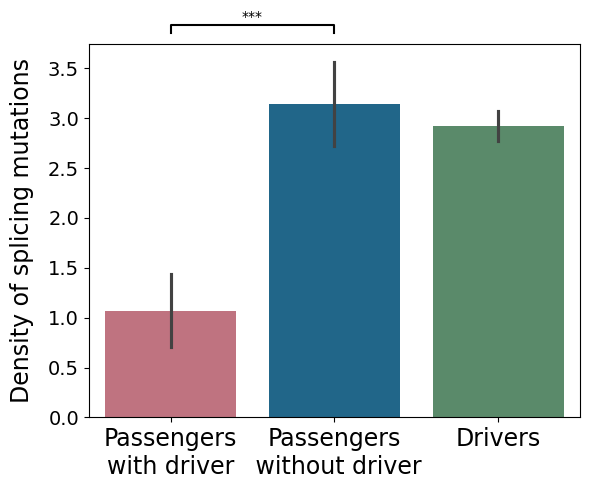

In [40]:
plt.figure(figsize=(6, 5))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
plot_data = splicing_change_density.copy()

ax = sns.barplot(
    x="driver_status",
    y="adj_splicing_density",
    data=plot_data,
    palette=cmap,
    order=order,
    errorbar="se", # standard error
)

annotator = Annotator(
    ax, 
    data=plot_data, 
    x="driver_status",
    y="adj_splicing_density",
    pairs=[("Passengers in presence of driver", "Passengers in absence of driver")],
    order=["Passengers in presence of driver", "Passengers in absence of driver"]
)
annotator.configure(test='t-test_ind', text_format='star', loc='outside', hide_non_significant=True, color='black')
annotator.apply_and_annotate()

plt.tight_layout()
plt.ylabel("Density of splicing mutations", fontsize=17, labelpad=10)
plt.yticks(fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=17, labels=["Passengers\nwith driver", "Passengers\n without driver", "Drivers"], ticks=[0, 1, 2])
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/splicing_mutation_density.svg", bbox_inches='tight', dpi=300)

# source data
splicing_change_density[["driver_status", "adj_splicing_density"]].to_csv(f"{PLOT_DATA_DIR}/splicing_mutation_density.tsv", sep="\t", index=False)

In [41]:
splicing_change_density_mean = splicing_change_density.groupby(["driver_status"]).agg({
	"adj_splicing_density": "mean"
}).reset_index()
with_driver = splicing_change_density_mean[splicing_change_density_mean["driver_status"] == "Passengers in presence of driver"]["adj_splicing_density"].values[0]
without_driver = splicing_change_density_mean[splicing_change_density_mean["driver_status"] == "Passengers in absence of driver"]["adj_splicing_density"].values[0]
fold_change = without_driver / with_driver
print(f"Fold change in splicing density: {fold_change}")

Fold change in splicing density: 2.9315675139156196


[(('TSG', 'Passengers in presence of driver'), ('TSG', 'Passengers in absence of driver')), (('OG', 'Passengers in presence of driver'), ('OG', 'Passengers in absence of driver'))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OG_Passengers in presence of driver vs. OG_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:2.605e-128 U_stat=1.273e+07
TSG_Passengers in presence of driver vs. TSG_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=8.244e+07


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99081/2288280734.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(


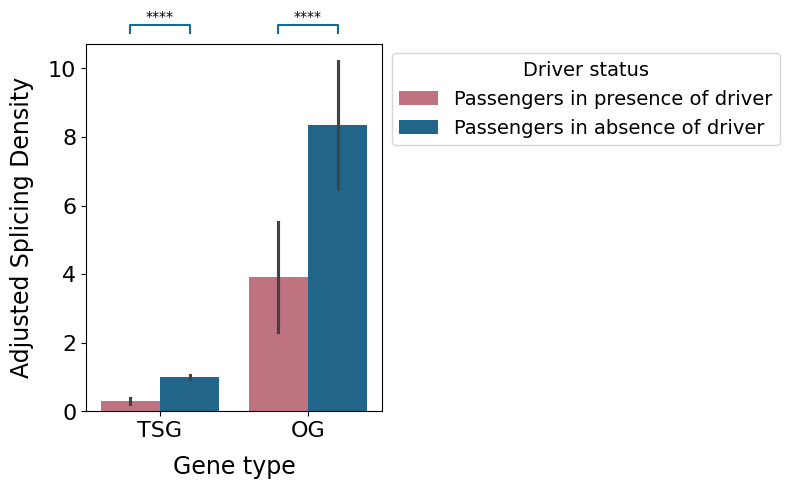

In [42]:
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver"]

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x="type",
    y="adj_splicing_density",
    hue="driver_status",
    data=plot_data[plot_data["type"].isin(["OG", "TSG"])],
    order=["TSG", "OG"],
    hue_order=hue_order,
    palette=cmap,
    errorbar="se", # standard error
)

# get statistical significance annotations
box_pairs = []
for gene_type in ["TSG", "OG"]:
    gene_data = plot_data[plot_data["type"] == gene_type]
    driver_statuses = gene_data["driver_status"].unique().tolist()
    if len(driver_statuses) >= 2:
        box_pairs.append(((gene_type, "Passengers in presence of driver"), (gene_type, "Passengers in absence of driver")))
print(box_pairs)

# get statistical significance annotations
annotator = Annotator(
    ax, 
    x="type",
    y="adj_splicing_density",
    hue="driver_status",
    data=plot_data[plot_data["type"].isin(["OG", "TSG"])],
    pairs=box_pairs,
    order=["TSG", "OG"],
    hue_order=hue_order,
)

annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xticks(fontsize=16)
plt.ylabel("Adjusted Splicing Density", fontsize=17, labelpad=10)
plt.xlabel("Gene type", fontsize=17, labelpad=10)
plt.yticks(fontsize=16)
plt.legend(title="Driver status", fontsize=14, title_fontsize=14, bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/splicing_density_by_gene_type.png", dpi=300)

# source data
splicing_change_density[splicing_change_density["type"].isin(["OG", "TSG"])][["driver_status", "type", "adj_splicing_density"]].to_csv(f"{PLOT_DATA_DIR}/splicing_density_by_gene_type.tsv", sep="\t", index=False)